# Detection

In [2]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Images

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

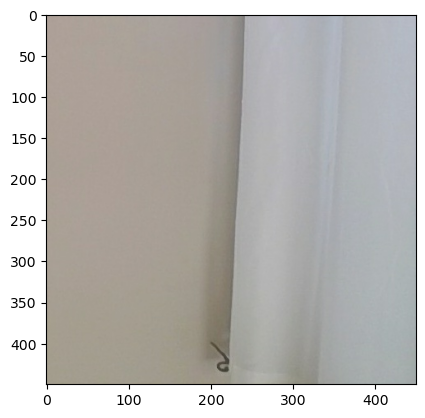

In [5]:
train_images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
plt.imshow(train_images.as_numpy_iterator().next())
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250))) #reducing data to parse through after
train_images = train_images.map(lambda x: x/255) # normalized image to be represented by values between 0-1 rather than 0-255

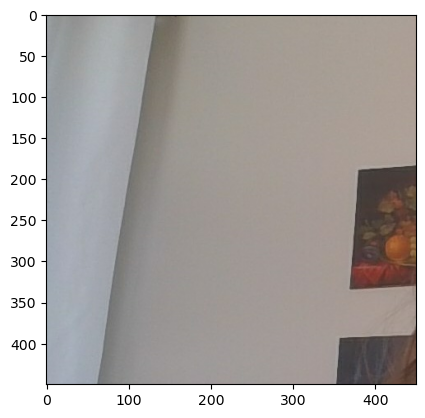

In [6]:
test_images = tf.data.Dataset.list_files('data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
plt.imshow(test_images.as_numpy_iterator().next())
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

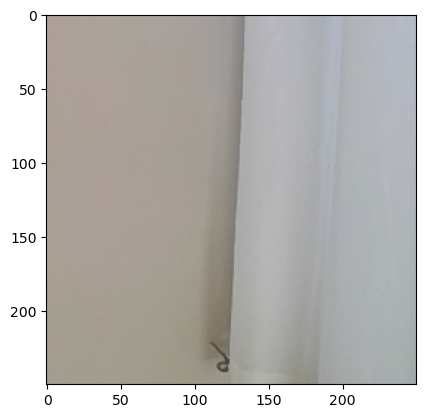

In [7]:
val_images = tf.data.Dataset.list_files('data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
plt.imshow(train_images.as_numpy_iterator().next())
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### Load Labels

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [9]:
train_labels = tf.data.Dataset.list_files('data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
# First 2: [X-Left Eye, Y-Left Eye]a
# Second 2: [X-Right Eye, Y-Right Eye]

In [11]:
test_labels = tf.data.Dataset.list_files('data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [12]:
val_labels = tf.data.Dataset.list_files('data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### Combining Labels and Images

In [13]:
# Lining up image with its respective labels
# Array element 0 is image, element 1 will be its eye coordinates
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000)
train = train.batch(16)
train = train.prefetch(4)

In [14]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(16)
test = test.prefetch(4)

In [15]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2200)
val = val.batch(16)
val = val.prefetch(4)

### Viewing Samples

In [16]:
data_samples = train.as_numpy_iterator()

In [17]:
res = data_samples.next()

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 'keypoints'
Traceback (most recent call last):

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\AppData\Local\Temp\ipykernel_8044\2821726087.py", line 4, in load_labels
    return [label['keypoints']]
            ~~~~~^^^^^^^^^^^^^

KeyError: 'keypoints'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# Building Model
### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [ ]:
# TO BE MODIFIED
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [ ]:
model.summary()

### Losses and Optimizers

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
model.compile(optimizer, loss)

### Sense Check Predictions

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
scores = model.predict(X)

In [ ]:
scores

### Train

In [ ]:
# Train for 100 epochs
hist = model.fit(train, epochs=1, validation_data=val)

### Review Performance

#### Loss Plots

In [ ]:
hist.history

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()